# old code

In [ ]:
import jax
import jax.numpy as jnp
import math
import numpy as np

In [3]:
# training data
num_trains = 10
num_tests = 200
input_dim = 1
output_dim = 1
x_train = jnp.linspace(-jnp.pi, jnp.pi, num_trains).reshape(num_trains, input_dim)
y_train = jnp.sin(x_train)
x_test = jnp.linspace(-jnp.pi, jnp.pi, num_tests).reshape(num_tests, input_dim)

In [57]:
feature_dim = 2
num_features = 1
num_bins = 3
std = 1 / jnp.sqrt(input_dim)
rng = jax.random.PRNGKey(42)

In [58]:
_rng, rng = jax.random.split(rng)
projection_matrix = std * jax.random.truncated_normal(
    key=_rng, lower=-2, upper=2, shape=(input_dim, feature_dim, num_features)
)

In [59]:
x = x_train[0:1]
y = y_train[0:1]
latent_vectors = jax.vmap(jnp.matmul, in_axes=[None, -1], out_axes=-1)(
    x, projection_matrix
)
latent_vectors = jax.nn.sigmoid(latent_vectors)
latent_vectors = latent_vectors * num_bins
latent_vectors, latent_vectors.shape

(Array([[[0.3790654],
         [2.6430423]]], dtype=float32),
 (1, 2, 1))

In [ ]:
indices = jnp.floor(latent_vectors).astype(jnp.int32)
offsets = latent_vectors - indices
indices = jnp.stack([indices, indices + 1], axis=-1)
# offsets = jnp.stack([1 - offsets, offsets], axis=-1)
offsets = jnp.stack([offsets, 1 - offsets], axis=-1)
offsets, offsets.shape, indices, indices.shape  # # [-1, feature_dim, num_features, 2]

(Array([[[[0.3790654 , 0.6209346 ]],
 
         [[0.6430423 , 0.35695767]]]], dtype=float32),
 (1, 2, 1, 2),
 Array([[[[0, 1]],
 
         [[2, 3]]]], dtype=int32),
 (1, 2, 1, 2))

In [ ]:
def _to_1d_index(indices, offsets, num_features, feature_dim, num_bins):
    """Compute the flattened index into the weight matrix."""
    n_grids_per_lsh = (num_bins + 1) ** feature_dim
    multiplier = jnp.power(num_bins + 1, jnp.arange(feature_dim - 1, -1, -1))
    indices *= multiplier[:, None, None]
    # shape = (-1, n_feat, ) + (2,) * bin_dim
    shape_suffix = [
        tuple(*p)
        for p in np.split(np.eye(feature_dim, dtype=np.int32) + 1, feature_dim)
    ]
    indices = sum(
        jnp.reshape(indices[:, i], (-1, num_features, *suffix))
        for i, suffix in enumerate(shape_suffix)
    )
    offsets = math.prod(
        jnp.reshape(offsets[:, i], (-1, num_features, *suffix))
        for i, suffix in enumerate(shape_suffix)
    )
    # both indices and offsets has the shape (-1, n_feat, *(2,)*bin_dim) now.
    indices += jnp.expand_dims(
        n_grids_per_lsh * jnp.arange(num_features),
        axis=tuple(range(-feature_dim, 1, 1)),
    )  # expand 1 dim in the front and bin_dim in the back.
    indices = jnp.reshape(indices, (-1, num_features * 2**feature_dim))
    offsets = jnp.reshape(offsets, (-1, num_features * 2**feature_dim))
    return indices, offsets

In [63]:
_to_1d_index(indices, offsets, num_features, feature_dim, num_bins)

(Array([[2, 3, 6, 7]], dtype=int32),
 Array([[0.24375509, 0.1353103 , 0.39928722, 0.22164737]], dtype=float32))

In [ ]:
def _my_to_1d_index(indices, offsets, num_features, feature_dim, num_bins):
    all_values = jnp.zeros(shape=(2**feature_dim * num_features), dtype=jnp.float32)
    all_indices = jnp.zeros_like(all_values, dtype=jnp.int32)
    for j in range(num_features):
        values = offsets[:, :, j, :]
        index = indices[:, :, j, :]
        # multiplier = jnp.power(num_bins, jnp.arange(feature_dim-1, -1,-1))
        if feature_dim > 1:
            for i in range(1, feature_dim):
                values = values @ offsets[:, i : i + 1, :, j].T
                values = values.reshape(-1, 1)
                index = index * (num_bins + 1) + indices[:, i, :, j]
                index = index.reshape(-1, 1)
        all_values = all_values.at[j * 2**feature_dim : (j + 1) * 2**feature_dim].add(
            values.flatten()
        )
        all_indices = all_indices.at[j * 2**feature_dim : (j + 1) * 2**feature_dim].add(
            (index + j * num_bins**feature_dim).astype(jnp.int32).flatten()
        )
        # print(values, values.shape, index, index.shape)

ValueError: Incompatible shapes for broadcasting: (2,) and requested shape (4,)

# new code

In [146]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

In [153]:
# training data
num_trains = 10
num_tests = 200
input_dim = 1
output_dim = 1
x_train = np.linspace(-np.pi, np.pi, num_trains).reshape(num_trains, input_dim)
y_train = np.sin(x_train)
x_test = np.linspace(-np.pi, np.pi, num_tests).reshape(num_tests, input_dim)
feature_dim = 2
num_features = 50
num_bins = 5
embedding_dim = (num_bins+1) ** feature_dim * num_features
std = 1 / np.sqrt(input_dim)
projection_matrix = std * np.random.normal(
    loc=0, scale=std, size=(num_features, input_dim, feature_dim)
)
# x = x_train[0]
# y = y_train[0]

In [154]:
def np_sigmoid(x: np.ndarray):
    return 1 / (1 + np.exp(-x))

In [155]:
x.shape, projection_matrix.shape

((1,), (50, 1, 2))

In [156]:
def latent_to_soft_one_hot(x: np.array, num_bins: int, feature_dim: int=2) -> np.ndarray:
    """
    Assuming feature_dim = 2
    Convert a latent vector to a soft one-hot encoding.
    x: element-wise in (0, 1)
    soft_one_hots_flatten: shape: (1, (num_bins + 1) ** num_features)
    """
    x = x * num_bins
    indices = np.floor(x).astype(np.int32)
    offsets = x - indices
    # indices = np.stack([indices, indices + 1], axis=-1)
    # offsets = np.stack([offsets, 1 - offsets], axis=-1)
    soft_one_hots = np.zeros((feature_dim, num_bins + 1))
    for index, offset, soh in zip(indices, offsets, soft_one_hots):
        soh[index] = offset
        soh[index + 1] = 1 - offset
    soft_one_hots_flatten = soft_one_hots[0:1]
    for i in range(1, feature_dim):
        soft_one_hots_flatten = soft_one_hots_flatten.T@soft_one_hots[i:i+1]
        soft_one_hots_flatten = soft_one_hots_flatten.reshape((1, -1))
    return indices, offsets, soft_one_hots, soft_one_hots_flatten

In [157]:
def calc_soft_one_hot(x: np.ndarray, projection_matrix: np.ndarray) -> np.ndarray:
    """_summary_

    Args:
        x (np.ndarray): _description_
        projection_matrix (np.ndarray): _description_

    Returns:
        np.ndarray: shape: [1, embedding_dim = num_bins ** feature_dim * num_features]
    """
    soft_one_hots_flattens = []
    for proj in projection_matrix:
        latent = x@proj
        latent = np_sigmoid(latent)
        _, _, _, soft_one_hots_flatten = latent_to_soft_one_hot(latent, num_bins, feature_dim)
        soft_one_hots_flattens.append(soft_one_hots_flatten)
    soft_one_hots_flattens = np.concatenate(soft_one_hots_flattens, axis=1)
    return soft_one_hots_flattens

In [158]:
matrix_A = np.zeros((embedding_dim, embedding_dim))
matrix_B = np.zeros((embedding_dim, output_dim))
matrix_W = np.zeros((embedding_dim, output_dim))

In [159]:
for x, y in zip(x_train, y_train):
    phi_x = calc_soft_one_hot(x, projection_matrix)
    matrix_A += phi_x.T@phi_x
    matrix_A += np.eye(embedding_dim) * 1e-6
    matrix_B += phi_x.T*y # TODO
    matrix_W += np.linalg.inv(matrix_A)@matrix_B

In [160]:
def predict(x: np.array, matrix_W: np.array):
    return calc_soft_one_hot(x, projection_matrix)@matrix_W

In [161]:
y_pred = []
for x in x_test:
    y_pred.append(predict(x, matrix_W)[0])

In [162]:
y_pred[0]

array([-1.97359449e-06])

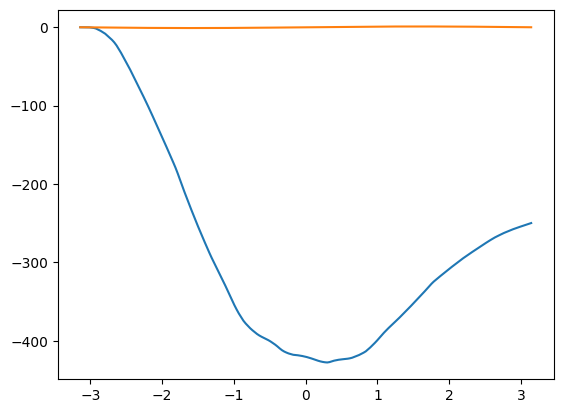

In [165]:
plt.plot(x_test, np.cumsum(y_pred))
plt.plot(x_test, np.sin(x_test))

In [145]:
indices, offsets, soft_one_hots, soft_one_hots_flatten = latent_to_soft_one_hot(latent, num_bins, feature_dim)
indices, indices.shape, offsets, soft_one_hots, soft_one_hots_flatten

(array([1, 0], dtype=int32),
 (2,),
 array([0.73259427, 0.16846155]),
 array([[0.        , 0.73259427, 0.26740573, 0.        ],
        [0.16846155, 0.83153845, 0.        , 0.        ]]),
 array([[0.        , 0.        , 0.        , 0.        , 0.12341397,
         0.6091803 , 0.        , 0.        , 0.04504758, 0.22235815,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ]]))